In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict
from lifelines import KaplanMeierFitter, CoxPHFitter

from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri, conversion
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import Formula
from rpy2.robjects.vectors import FloatVector, IntVector, ListVector, Vector

rstpm2 = importr("rstpm2")
survival = importr("survival")
ggplot2 = importr("ggplot2")
graphics = importr("graphics")
stats = importr("stats")
lmtest = importr("lmtest")

In [36]:
dfs = pd.read_csv('survival_data.csv')
df1 = dfs.copy()
df1.head(3)

,time,event,age,treatment
0,7.483810,1,64.967142,1
1,22.360127,0,58.617357,1
2,6.562908,1,66.476885,0


In [37]:

with conversion.localconverter(pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df1)

In [38]:
## Fit a flexible parametric survival model (baseline model)
# The baseline log-cumulative-hazard 

# # Define the formula
formula = Formula('Surv(time, event==1) ~ treatment')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_df, df=3)
print(ro.r.summary(fp_model))

Maximum likelihood estimation

Call:
(function (formula, data, weights = NULL, subset = NULL, coxph.strata = NULL, 
    ...) 
{
    m <- match.call()
    m[[1L]] <- quote(gsm)
    m$penalised <- FALSE
    out <- eval(m, data, parent.frame())
    out@Call <- match.call()
    out
})(formula = Surv(time, event == 1) ~ treatment, data = list(
    time = c(7.48381039685687, 22.3601270252418, 6.56290768656722, 
    25.7839713848249, 32.9211746476886, 9.8806616759519, 26.0923699853616, 
    6.67209455104277, 7.41347501510736, 15.4717659739793, 5.8183198942738, 
    26.5752543562231, 12.8417198875872, 2.76238980203114, 16.1383683068996, 
    39.5440571465394, 14.6027029563604, 15.233956954902, 4.04596415256261, 
    20.1490089382581, 8.67622574932543, 22.3808714988439, 3.35089028507582, 
    27.309919406079, 13.7623393946028, 5.05078122417244, 6.62623363709242, 
    4.61514717728804, 16.9133266758975, 24.3530959409468, 30.3126468875489, 
    8.27965090257324, 8.74193136302063, 16.4705571809581

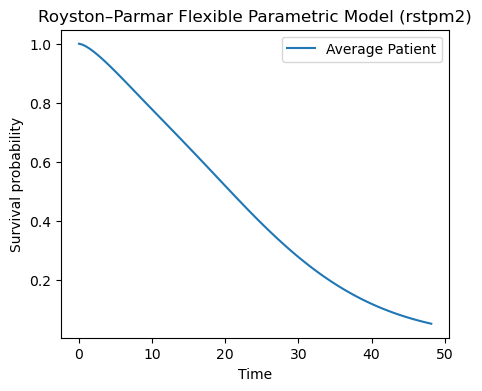

In [39]:
# ────────────────────────────────────────────────────
# Prediction (survival at specific times) for the average patient
# ────────────────────────────────────────────────────
times = ro.FloatVector(np.linspace(0, df1["time"].max(), 100))

# Compute mean treatment value (continuous or binary)
mean_treat = float(df1["treatment"].mean())
# mean_treat

# Create R newdata
newdata_r = ro.DataFrame({"treatment": FloatVector([mean_treat]*100),
                          "time": times})
# newdata_r

# Prediction for the average patient
r_predict = r['predict']
S = r_predict(fp_model, newdata=newdata_r, type="surv")

# Convert predictions back to Python
with localconverter(default_converter + pandas2ri.converter):
    py_S = np.array(S)

# ────────────────────────────────────────────────────
# Plot survival curves in Python
# ────────────────────────────────────────────────────
plt.figure(figsize=(5,4))
plt.plot(times, py_S, label="Average Patient")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()


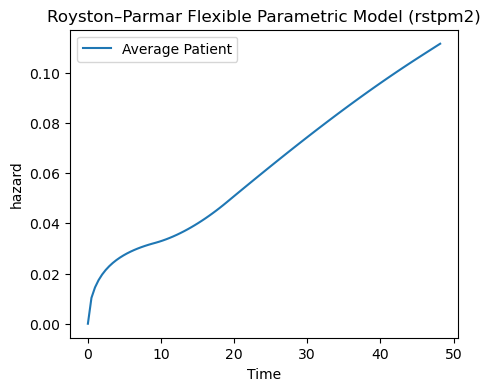

In [40]:
# ────────────────────────────────────────────────────
# Prediction (Hazard at specific times) for the average patient
# ────────────────────────────────────────────────────
times = ro.FloatVector(np.linspace(0, df1["time"].max(), 100))

# Compute mean treatment value (continuous or binary)
mean_treat = float(df1["treatment"].mean())
# mean_treat

# Create R newdata
newdata_r = ro.DataFrame({"treatment": FloatVector([mean_treat]*100),
                          "time": times})
# newdata_r

# Prediction for the average patient
r_predict = r['predict']
S = r_predict(fp_model, newdata=newdata_r, type="hazard")

# Convert predictions back to Python
with localconverter(default_converter + pandas2ri.converter):
    py_S = np.array(S)

# ────────────────────────────────────────────────────
# Plot hazard curves in Python
# ────────────────────────────────────────────────────
plt.figure(figsize=(5,4))
plt.plot(times, py_S, label="Average Patient")
plt.xlabel("Time")
plt.ylabel("hazard")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

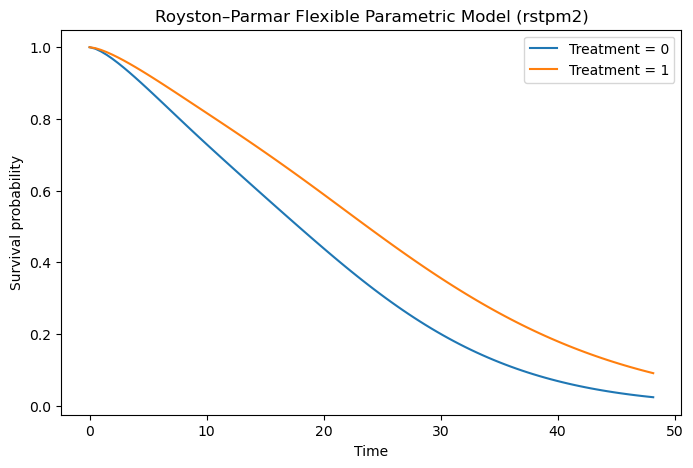

In [41]:
# ────────────────────────────────────────────────────
# Prediction (survival at specific times)
# ────────────────────────────────────────────────────
times = ro.FloatVector(np.linspace(0, df1["time"].max(), 100))

# Prediction for treatment=0
newdata0 = ro.DataFrame({"treatment": ro.IntVector([0]*100),
                         "time": times})
r_predict = r['predict']
S0 = r_predict(fp_model, newdata=newdata0, type="surv")

# Prediction for treatment=1
newdata1 = ro.DataFrame({"treatment": ro.IntVector([1]*100),
                         "time": times})
S1 = r_predict(fp_model, newdata=newdata1, type="surv")

# Convert predictions back to Python
with localconverter(default_converter + pandas2ri.converter):
    py_S0 = np.array(S0)
    py_S1 = np.array(S1)

# ────────────────────────────────────────────────────
# Plot survival curves in Python
# ────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
plt.plot(times, py_S0, label="Treatment = 0")
plt.plot(times, py_S1, label="Treatment = 1")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

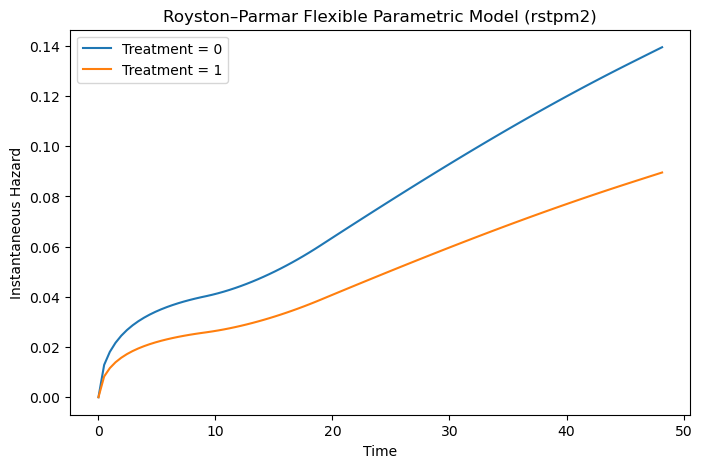

In [42]:
# ────────────────────────────────────────────────────
# Prediction (hazard at specific times)
# ────────────────────────────────────────────────────
times = ro.FloatVector(np.linspace(0, df1["time"].max(), 100))

# Prediction for treatment=0
newdata0 = ro.DataFrame({"treatment": ro.IntVector([0]*100),
                         "time": times})
r_predict = r['predict']
S0 = r_predict(fp_model, newdata=newdata0, type="hazard")

# Prediction for treatment=1
newdata1 = ro.DataFrame({"treatment": ro.IntVector([1]*100),
                         "time": times})
S1 = r_predict(fp_model, newdata=newdata1, type="hazard")

# Convert predictions back to Python
with localconverter(default_converter + pandas2ri.converter):
    py_S0 = np.array(S0)
    py_S1 = np.array(S1)


# ────────────────────────────────────────────────────
# Plot hazard curves in Python
# ────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
plt.plot(times, py_S0, label="Treatment = 0")
plt.plot(times, py_S1, label="Treatment = 1")
plt.xlabel("Time")
plt.ylabel("Instantaneous Hazard")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

In [43]:
# # Returning predictions to Python
# with localconverter(default_converter + pandas2ri.converter):
#     py_S0 = np.array(S0)

# # Now you can use them in NumPy, pandas, or matplotlib.

In [44]:
## Adds a time-varying effect for the variable hormon, tvc=list(hormon=3)
# This allows hazard ratio between hormon vs no-hormon to change over time.

# # Define the formula
formula = Formula('Surv(time, event==1) ~ treatment')

# tvc = list(treatment = 3)  →  ListVector({"treatment": IntVector([3])})
tvc_r = ListVector({"treatment": IntVector([3])})


# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model1 = rstpm2.stpm2(formula, data=r_df, df=3, tvc=tvc_r)
print(ro.r.summary(fp_model1))

Maximum likelihood estimation

Call:
(function (formula, data, weights = NULL, subset = NULL, coxph.strata = NULL, 
    ...) 
{
    m <- match.call()
    m[[1L]] <- quote(gsm)
    m$penalised <- FALSE
    out <- eval(m, data, parent.frame())
    out@Call <- match.call()
    out
})(formula = Surv(time, event == 1) ~ treatment, data = list(
    time = c(7.48381039685687, 22.3601270252418, 6.56290768656722, 
    25.7839713848249, 32.9211746476886, 9.8806616759519, 26.0923699853616, 
    6.67209455104277, 7.41347501510736, 15.4717659739793, 5.8183198942738, 
    26.5752543562231, 12.8417198875872, 2.76238980203114, 16.1383683068996, 
    39.5440571465394, 14.6027029563604, 15.233956954902, 4.04596415256261, 
    20.1490089382581, 8.67622574932543, 22.3808714988439, 3.35089028507582, 
    27.309919406079, 13.7623393946028, 5.05078122417244, 6.62623363709242, 
    4.61514717728804, 16.9133266758975, 24.3530959409468, 30.3126468875489, 
    8.27965090257324, 8.74193136302063, 16.4705571809581

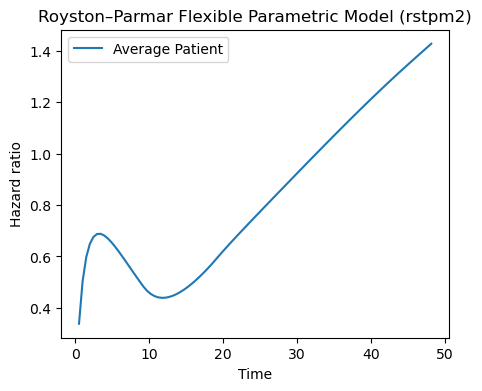

In [45]:
# ────────────────────────────────────────────────────
# Prediction (Hazard ratio at specific times) for the average patient
# ────────────────────────────────────────────────────
times = ro.FloatVector(np.linspace(0, df1["time"].max(), 100))

# Compute mean treatment value (continuous or binary)
mean_treat = float(df1["treatment"].mean())
# mean_treat

# Create R newdata
newdata_r = ro.DataFrame({"treatment": FloatVector([mean_treat]*100),
                          "time": times})
# newdata_r

# Prediction for the average patient
r_predict = r['predict']
S = r_predict(fp_model1, newdata=newdata_r, type="hr",var="treatment")

# Convert predictions back to Python
with localconverter(default_converter + pandas2ri.converter):
    py_S = np.array(S)

# ────────────────────────────────────────────────────
# Plot Hazard ratio" curves in Python
# ────────────────────────────────────────────────────
plt.figure(figsize=(5,4))
plt.plot(times, py_S, label="Average Patient")
plt.xlabel("Time")
plt.ylabel("Hazard ratio")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

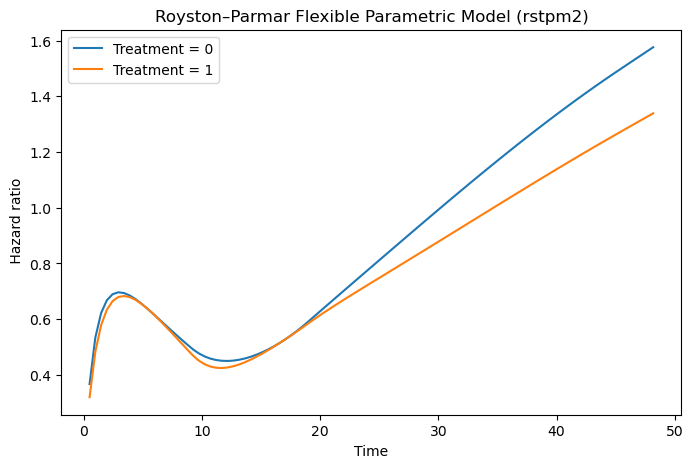

In [46]:
# ────────────────────────────────────────────────────
# Prediction (hazard at specific times)
# ────────────────────────────────────────────────────
times = ro.FloatVector(np.linspace(0, df1["time"].max(), 100))

# Prediction for treatment=0
newdata0 = ro.DataFrame({"treatment": ro.IntVector([0]*100),
                         "time": times})
r_predict = r['predict']
S0 = r_predict(fp_model1, newdata=newdata0, type="hr",var="treatment")

# Prediction for treatment=1
newdata1 = ro.DataFrame({"treatment": ro.IntVector([1]*100),
                         "time": times})
S1 = r_predict(fp_model1, newdata=newdata1, type="hr",var="treatment")

# Convert predictions back to Python
with localconverter(default_converter + pandas2ri.converter):
    py_S0 = np.array(S0)
    py_S1 = np.array(S1)


# ────────────────────────────────────────────────────
# Plot hazard curves in Python
# ────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
plt.plot(times, py_S0, label="Treatment = 0")
plt.plot(times, py_S1, label="Treatment = 1")
plt.xlabel("Time")
plt.ylabel(" Hazard ratio")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

In [47]:
# Perform likelihood ratio test between two models





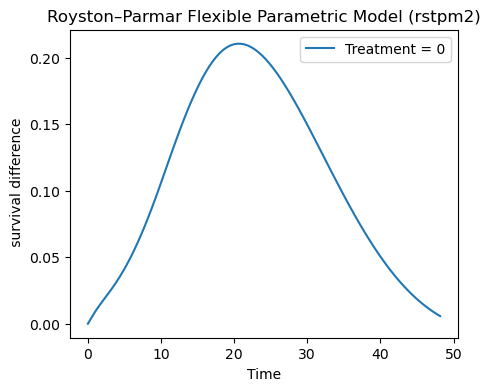

In [48]:
# ────────────────────────────────────────────────────
# Plot survival differences and hazard differences
# Plots difference in survival between hormon=1 vs 0 over time.
# ────────────────────────────────────────────────────
times = ro.FloatVector(np.linspace(0, df1["time"].max(), 100))

# Prediction for treatment=0
newdata0 = ro.DataFrame({"treatment": ro.IntVector([0]*100),
                         "time": times})
r_predict = r['predict']
S0 = r_predict(fp_model1, newdata=newdata0, type="sdiff",var="treatment")

# # Prediction for treatment=1
# newdata1 = ro.DataFrame({"treatment": ro.IntVector([1]*100),
#                          "time": times})
# S1 = r_predict(fp_model1, newdata=newdata1, type="hr",var="treatment")

# Convert predictions back to Python
with localconverter(default_converter + pandas2ri.converter):
    py_S0 = np.array(S0)
    # py_S1 = np.array(S1)


# ────────────────────────────────────────────────────
# Plot hazard curves in Python
# ────────────────────────────────────────────────────
plt.figure(figsize=(5,4))
plt.plot(times, py_S0, label="Treatment = 0")
# plt.plot(times, py_S1, label="Treatment = 1")
plt.xlabel("Time")
plt.ylabel(" survival difference")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

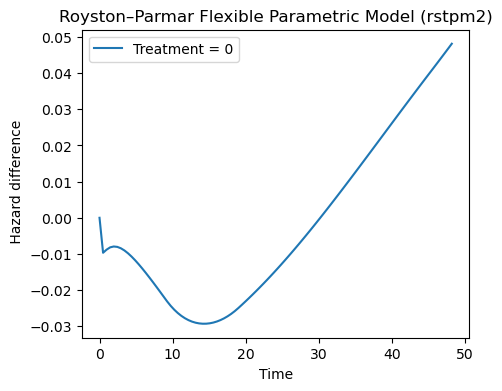

In [49]:
# ────────────────────────────────────────────────────
# Plot survival differences and hazard differences
# Plots difference in hazard between hormon=1 vs 0 over time.
# ────────────────────────────────────────────────────
times = ro.FloatVector(np.linspace(0, df1["time"].max(), 100))

# Prediction for treatment=0
newdata0 = ro.DataFrame({"treatment": ro.IntVector([0]*100),
                         "time": times})
r_predict = r['predict']
S0 = r_predict(fp_model1, newdata=newdata0, type="hdiff",var="treatment")

# # Prediction for treatment=1
# newdata1 = ro.DataFrame({"treatment": ro.IntVector([1]*100),
#                          "time": times})
# S1 = r_predict(fp_model1, newdata=newdata1, type="hr",var="treatment")

# Convert predictions back to Python
with localconverter(default_converter + pandas2ri.converter):
    py_S0 = np.array(S0)
    # py_S1 = np.array(S1)


# ────────────────────────────────────────────────────
# Plot hazard curves in Python
# ────────────────────────────────────────────────────
plt.figure(figsize=(5,4))
plt.plot(times, py_S0, label="Treatment = 0")
# plt.plot(times, py_S1, label="Treatment = 1")
plt.xlabel("Time")
plt.ylabel(" Hazard difference")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

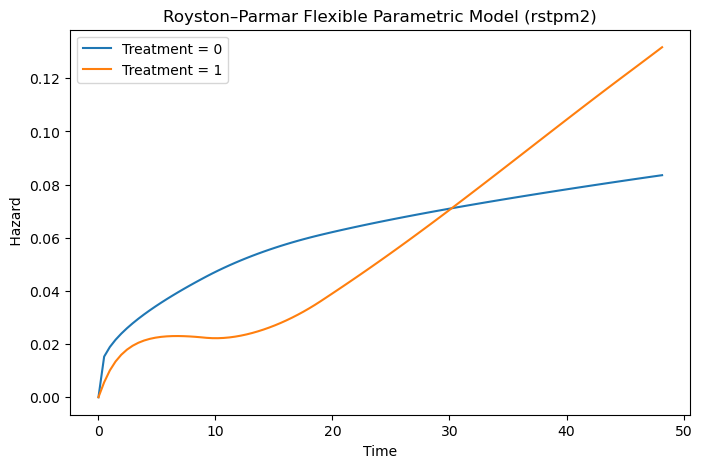

In [50]:
# ────────────────────────────────────────────────────
# Prediction (hazard at specific times)
# ────────────────────────────────────────────────────
times = ro.FloatVector(np.linspace(0, df1["time"].max(), 100))

# Prediction for treatment=0
newdata0 = ro.DataFrame({"treatment": ro.IntVector([0]*100),
                         "time": times})
r_predict = r['predict']
S0 = r_predict(fp_model1, newdata=newdata0, type="hazard",var="treatment")

# Prediction for treatment=1
newdata1 = ro.DataFrame({"treatment": ro.IntVector([1]*100),
                         "time": times})
S1 = r_predict(fp_model1, newdata=newdata1, type="hazard",var="treatment")

# Convert predictions back to Python
with localconverter(default_converter + pandas2ri.converter):
    py_S0 = np.array(S0)
    py_S1 = np.array(S1)


# ────────────────────────────────────────────────────
# Plot hazard curves in Python
# ────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
plt.plot(times, py_S0, label="Treatment = 0")
plt.plot(times, py_S1, label="Treatment = 1")
plt.xlabel("Time")
plt.ylabel(" Hazard")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

df=0, AIC=2361.96
df=1, AIC=2361.96
df=2, AIC=2362.49
df=3, AIC=2361.74
df=4, AIC=2361.94
df=5, AIC=2363.33
df=6, AIC=2364.37


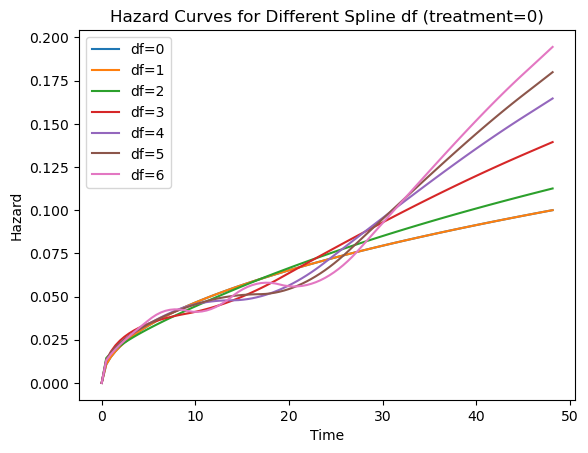

In [51]:
# # Define the formula Baseline hazard curve for treatment=0
formula = Formula('Surv(time, event==1) ~ treatment')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
for df_val in [0,1,2,3,4,5,6]:
    fp_model2 = rstpm2.stpm2(formula, data=r_df, df=df_val)
    
    # Print AIC
    aic_val = stats.AIC(fp_model2)[0]
    print(f"df={df_val}, AIC={aic_val:.2f}")

    newdata0 = ro.DataFrame({"treatment": ro.IntVector([0]*len(times)),
                         "time": times})
    r_predict = r['predict']
    S0 = r_predict(fp_model2, newdata=newdata0, type="hazard")

    # Convert predictions back to Python
    with localconverter(default_converter + pandas2ri.converter):
        py_S0 = np.array(S0)

    # Plot on same figure
    plt.plot(times, py_S0, label=f"df={df_val}")

plt.xlabel("Time")
plt.ylabel("Hazard")
plt.title("Hazard Curves for Different Spline df (treatment=0)")
plt.legend()
plt.show()


In [52]:
## Prognostic Scores for Baseline Model (fit)
# prognostic score (linear predictor) with standard error
r_predict = r['predict']

df1["prognostic_score"] = r_predict(fp_model, type = "link")

df1.head(6)

,time,event,age,treatment,prognostic_score
0,7.483810,1,64.967142,1,-1.978639
1,22.360127,0,58.617357,1,-0.461978
2,6.562908,1,66.476885,0,-1.711546
3,25.783971,0,75.230299,1,-0.227557
4,32.921175,1,57.658466,1,0.193570
5,9.880662,1,57.658630,0,-1.169522


In [53]:
df1['risk_group'] = pd.qcut(df1['prognostic_score'], 3, labels=['Low','Medium','High'])

df1.head(6)
df1.risk_group.value_counts().to_dict()

{'Low': 167, 'High': 167, 'Medium': 166}

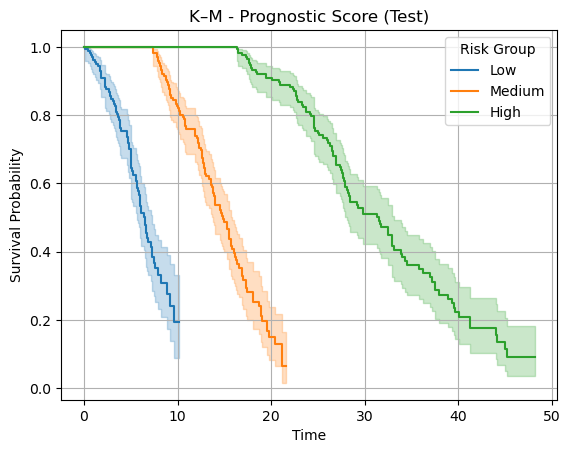

In [54]:
for group in ['Low','Medium','High']:
    subset = df1[df1['risk_group']==group]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['time'], subset['event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score (Test)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.grid(True)
plt.show()

In [55]:
df1.head(3)

,time,event,age,treatment,prognostic_score,risk_group
0,7.483810,1,64.967142,1,-1.978639,Low
1,22.360127,0,58.617357,1,-0.461978,High
2,6.562908,1,66.476885,0,-1.711546,Low


In [56]:
# Candidate covariates (modify for your dataset)
covariates = [
    "treatment",
    "age"
    ]

df_candidates = [0,1, 2, 3, 4, 5, 6]

In [57]:
# backward stepwise selection based on AIC and spline df selection

def fit_model_and_get_aic(vars_list, df_spline):
    rhs = " + ".join(vars_list) if vars_list else "1"
    formula_str = f"Surv(time, event==1) ~ {rhs}"
    formula = Formula(formula_str)
    
    try:
        model = rstpm2.stpm2(formula, data=r_df, df=df_spline)
        aic = stats.AIC(model)[0]
        return model, aic, formula_str
    except Exception:
        return None, np.inf, formula_str


best_overall = {
    "model": None,
    "aic": np.inf,
    "formula": None,
    "df": None
}

current_vars = covariates.copy()

while True:
    candidates = []

    # Try all dfs with current variable set
    for df_spline in df_candidates:
        model, aic, f_str = fit_model_and_get_aic(current_vars, df_spline)
        candidates.append((aic, model, f_str, df_spline, current_vars.copy()))

    # Try removing each variable (backward step)
    for var in current_vars:
        test_vars = [v for v in current_vars if v != var]
        for df_spline in df_candidates:
            model, aic, f_str = fit_model_and_get_aic(test_vars, df_spline)
            candidates.append((aic, model, f_str, df_spline, test_vars.copy()))

    # Pick best candidate
    best_step = min(candidates, key=lambda x: x[0])

    best_aic, best_model, best_formula, best_df, best_vars = best_step

    # Stop if no improvement
    if best_aic >= best_overall["aic"]:
        break

    # Update best
    best_overall.update({
        "model": best_model,
        "aic": best_aic,
        "formula": best_formula,
        "df": best_df
    })

    current_vars = best_vars

print("\n✅ Final selected model:")
print("Formula:", best_overall["formula"])
print("Spline df:", best_overall["df"])
print("AIC:", best_overall["aic"])

final_model = best_overall["model"]



✅ Final selected model:
Formula: Surv(time, event==1) ~ treatment + age
Spline df: 3
AIC: 2351.98559939464


In [58]:
from sklearn.model_selection import KFold

In [59]:
def cv_aic_for_model(df_python, vars_list, spline_df, n_splits=5):
    """
    Compute mean cross-validated AIC for a given variable set and spline df
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    aics = []

    rhs = " + ".join(vars_list) if vars_list else "1"
    formula_str = f"Surv(time, event==1) ~ {rhs}"
    formula = Formula(formula_str)

    for train_idx, test_idx in kf.split(df_python):
        train_df = df_python.iloc[train_idx]

        # Convert fold to R
        with localconverter(default_converter + pandas2ri.converter):
            r_train = pandas2ri.py2rpy(train_df)

        try:
            model = rstpm2.stpm2(formula, data=r_train, df=spline_df)
            aic = stats.AIC(model)[0]
            aics.append(aic)
        except Exception:
            aics.append(np.inf)

    return np.mean(aics)


In [60]:
covariates = [
    "treatment",
    "age"
]

df_candidates = [1, 2, 3, 4, 5, 6]
n_splits = 5

current_vars = covariates.copy()
best_score = np.inf
best_vars = current_vars
best_df = None

while True:
    candidates = []

    # Try current model with different dfs
    for df_spline in df_candidates:
        score = cv_aic_for_model(df1, current_vars, df_spline, n_splits)
        candidates.append((score, current_vars, df_spline))

    # Try removing each variable
    for var in current_vars:
        test_vars = [v for v in current_vars if v != var]
        for df_spline in df_candidates:
            score = cv_aic_for_model(df1, test_vars, df_spline, n_splits)
            candidates.append((score, test_vars, df_spline))

    # Pick best candidate
    best_candidate = min(candidates, key=lambda x: x[0])

    cand_score, cand_vars, cand_df = best_candidate

    # Stop if no improvement
    if cand_score >= best_score:
        break

    best_score = cand_score
    best_vars = cand_vars
    best_df = cand_df
    current_vars = cand_vars

print("\n✅ Selected model by CV-AIC:")
print("Variables:", best_vars)
print("Spline df:", best_df)
print("CV-AIC:", best_score)



✅ Selected model by CV-AIC:
Variables: ['treatment', 'age']
Spline df: 3
CV-AIC: 1882.338311723925


In [61]:

def predict_survival_multi(fp_model, newdata, max_time=None):
    """
    Predict survival curves for multiple rows in newdata.

    Args:
        fp_model: Fitted stpm2 R model object
        newdata: pandas DataFrame with covariates
        max_time: float, maximum time for survival curve. If None, set to 1.0

    Returns:
        pandas DataFrame in long format with columns:
        - id: row index of newdata
        - time: time points
        - surv: survival probability
    """
    r_predict = r['predict']

    if max_time is None:
        max_time = 1.0

    all_dfs = []

    # Loop over each row
    for idx, row in newdata.iterrows():
        row_df = pd.DataFrame([row])  # single-row DataFrame

        with localconverter(default_converter + pandas2ri.converter):
            r_row = pandas2ri.py2rpy(row_df)
            surv_pred = r_predict(fp_model, newdata=r_row, type="surv", grid=True)

        # Convert R numeric vector to numpy
        surv_values = np.array(surv_pred)
        n_points = len(surv_values)

        # Create time grid
        time_grid = np.linspace(0, max_time, n_points)

        # Build DataFrame
        df = pd.DataFrame({
            "id": idx,
            "time": time_grid,
            "surv": surv_values
        })

        all_dfs.append(df)

    # Concatenate all rows
    return pd.concat(all_dfs, ignore_index=True)


In [62]:
# Predict survival for all rows
surv_long0 = predict_survival_multi(fp_model, newdata = df1, max_time=df1['time'].max())
print(surv_long0.head())

   id      time      surv
0   0  0.000000  0.998896
1   0  0.161643  0.997844
2   0  0.323287  0.996579
3   0  0.484930  0.995139
4   0  0.646573  0.993548


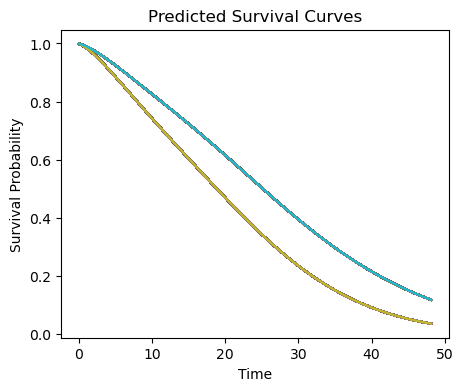

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))

for idx in surv_long0['id'].unique():
    df = surv_long0[surv_long0['id'] == idx]
    plt.plot(df['time'], df['surv'], label=f'Row {idx}')

plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curves")
# plt.legend()
plt.show()

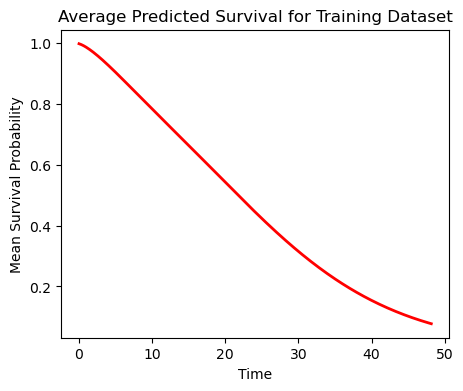

In [64]:
# Average survival curve (overall population)
# Pivot to have time as index, rows as individuals
surv_wide = surv_long0.pivot(index='time', columns='id', values='surv')

# Calculate mean survival at each time
mean_surv = surv_wide.mean(axis=1)

# Plot population-level survival curve
plt.figure(figsize=(5,4))
plt.plot(mean_surv.index, mean_surv.values, color='red', lw=2)
plt.xlabel("Time")
plt.ylabel("Mean Survival Probability")
plt.title("Average Predicted Survival for Training Dataset")
plt.show()


In [65]:
# ---------- low-level helper to call predict safely --------------
def _predict_row_raw(fp_model, row_df, pred_type="surv", se_fit=False):
    """
    Call R predict for a single-row pandas DataFrame and return raw numpy arrays.

    Returns dict with keys:
      - est: numpy array of predicted values (surv/hazard/cumhaz)
      - se: numpy array of standard errors or None
    """
    with localconverter(default_converter + pandas2ri.converter):
        r_row = pandas2ri.py2rpy(row_df)  # convert to R df
        # call predict
        pred = r['predict'](fp_model, newdata=r_row, type=pred_type, grid=True, se_fit=se_fit)

    # pred can be:
    #  - an R numeric vector -> rpy2 converts to FloatVector / numpy array
    #  - an R list / named vector (ListVector) or matrix
    # We'll try to extract est and se if present.

    # Case A: pred is FloatVector (single numeric vector)
    if isinstance(pred, FloatVector) or isinstance(pred, Vector) and not isinstance(pred, ListVector):
        est = np.array(pred)
        se = None
        return {"est": est, "se": se}

    # Case B: pred is ListVector (R list) - may contain 'est' and 'se'
    if isinstance(pred, ListVector):
        # try common names
        out = {}
        if "est" in pred.names:
            out["est"] = np.array(pred.rx2("est"))
        elif "surv" in pred.names:
            out["est"] = np.array(pred.rx2("surv"))
        elif "estimate" in pred.names:
            out["est"] = np.array(pred.rx2("estimate"))
        else:
            # fallback: try convert full object to numpy if possible
            try:
                out["est"] = np.array(pred[0])
            except Exception:
                raise RuntimeError("Couldn't extract estimate from predict() output ListVector.")

        if se_fit:
            if "se" in pred.names:
                out["se"] = np.array(pred.rx2("se"))
            elif "se.fit" in pred.names:
                out["se"] = np.array(pred.rx2("se.fit"))
            else:
                # maybe se is second element of matrix-like object
                out["se"] = None
        else:
            out["se"] = None
        return out

    # Case C: pred is some other Vector/array-like (e.g., 2-column matrix)
    try:
        arr = np.array(pred)
        # If arr is 2D with second col = se
        if arr.ndim == 2 and arr.shape[1] >= 1:
            est = arr[:, 0]
            se = arr[:, 1] if (arr.shape[1] > 1 and se_fit) else None
            return {"est": est, "se": se}
        else:
            return {"est": arr.flatten(), "se": None}
    except Exception as e:
        raise RuntimeError(f"Unhandled predict() return type: {type(pred)} -> {e}")



In [66]:
# ---------- multi-row predictor (long format) --------------
def predict_type_multi(fp_model, data: pd.DataFrame, pred_type: str = "surv",
                       max_time: Optional[float] = None, se_fit: bool = False) -> pd.DataFrame:
    """
    Predict `pred_type` ("surv", "hazard", "cumhaz", "fail") for each row in `data`.

    Returns long-format DataFrame with columns:
      id (index of row in data), time, value (predicted), se (if se_fit and available, else NaN)
    """
    N = len(data)
    results = []
    # decide max_time fallback
    if max_time is None:
        if "time" in data.columns:
            max_time = float(data["time"].max())
        else:
            max_time = 1.0

    # We'll get grid length from first row
    first_row = data.iloc[[0]]
    raw0 = _predict_row_raw(fp_model, first_row, pred_type, se_fit=se_fit)
    n_points = len(raw0["est"])

    # create time grid based on max_time and n_points
    time_grid = np.linspace(0, max_time, n_points)

    # first row append
    se0 = raw0.get("se", None)
    for i, v in enumerate(raw0["est"]):
        results.append({"id": 0, "time": time_grid[i], "value": float(v),
                        "se": float(se0[i]) if se0 is not None else np.nan})

    # subsequent rows
    for idx in range(1, N):
        row_df = data.iloc[[idx]]
        raw = _predict_row_raw(fp_model, row_df, pred_type, se_fit=se_fit)
        est = raw["est"]
        se = raw.get("se", None)
        if len(est) != n_points:
            # if different grid length, resample/interpolate to common time_grid (rare)
            # We'll interpolate original to the common grid
            src_t = np.linspace(0, max_time, len(est))
            est = np.interp(time_grid, src_t, est)
            if se is not None:
                se = np.interp(time_grid, src_t, se)
        for i, v in enumerate(est):
            results.append({"id": int(idx), "time": time_grid[i], "value": float(v),
                            "se": float(se[i]) if (se is not None) else np.nan})

    long_df = pd.DataFrame(results)
    return long_df

# hazard long-format
haz_long = predict_type_multi(fp_model, df1, pred_type="hazard", max_time=df1['time'].max(), se_fit=False)
cumhaz_long = predict_type_multi(fp_model, df1, pred_type="cumhaz", max_time=df1['time'].max(), se_fit=False)
surv_long1 = predict_type_multi(fp_model, df1, pred_type="surv", max_time=df1['time'].max(), se_fit=False)

In [67]:
print(f"{haz_long.head()}\n")
print(f"{cumhaz_long.head()}\n")
print(f"{surv_long1.head()}")

   id      time     value  se
0   0  0.000000  0.006164 NaN
1   0  0.161643  0.007748 NaN
2   0  0.323287  0.009034 NaN
3   0  0.484930  0.010127 NaN
4   0  0.646573  0.011081 NaN

   id      time     value  se
0   0  0.000000  0.001105 NaN
1   0  0.161643  0.002159 NaN
2   0  0.323287  0.003427 NaN
3   0  0.484930  0.004873 NaN
4   0  0.646573  0.006473 NaN

   id      time     value  se
0   0  0.000000  0.998896 NaN
1   0  0.161643  0.997844 NaN
2   0  0.323287  0.996579 NaN
3   0  0.484930  0.995139 NaN
4   0  0.646573  0.993548 NaN


In [68]:
# ---------- average curve and model-based pointwise CI --------------
def average_curve_from_long(long_df: pd.DataFrame) -> Tuple[pd.Series, pd.Series]:
    """
    Compute average (mean) predicted curve and model-based pointwise SE for the average.
    long_df columns: id, time, value, se (se may be NaN if unavailable)

    Returns (avg_series, se_avg_series)
    - avg_series: index = time, values = mean(value across ids)
    - se_avg_series: pointwise SE for average computed as sqrt( sum(se_i^2) ) / N if se available,
      otherwise returns a series of NaNs.
    """
    pivot = long_df.pivot(index="time", columns="id", values="value")
    avg = pivot.mean(axis=1)

    # se calculation: if `se` available per-id and timepoint
    se_pivot = None
    if "se" in long_df.columns and not long_df["se"].isna().all():
        se_pivot = long_df.pivot(index="time", columns="id", values="se")
        # variance of average = (1/N^2) * sum Var(S_i) approximated by sum se_i^2 / N^2
        N = se_pivot.shape[1]
        se_avg = np.sqrt((se_pivot ** 2).sum(axis=1)) / N
    else:
        se_avg = pd.Series(np.nan, index=avg.index)

    return avg, se_avg


# ---------- confidence bands (normal approx) --------------
def pointwise_CI(avg_series: pd.Series, se_series: pd.Series, alpha=0.05) -> Tuple[pd.Series, pd.Series]:
    z = abs(np.round(np.quantile(np.random.standard_normal(1000000), 1 - alpha/2), 6))  # approximate z
    # but simpler: use scipy? avoid extra deps: z for 0.975 ~1.96
    z = 1.96
    lower = avg_series - z * se_series
    upper = avg_series + z * se_series
    # clamp to [0,1] if survival
    lower = lower.clip(0, 1)
    upper = upper.clip(0, 1)
    return lower, upper

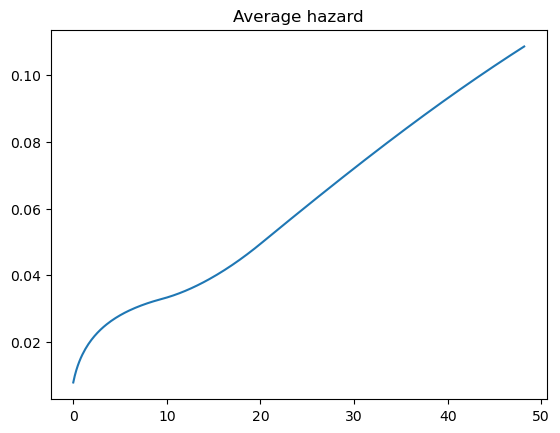

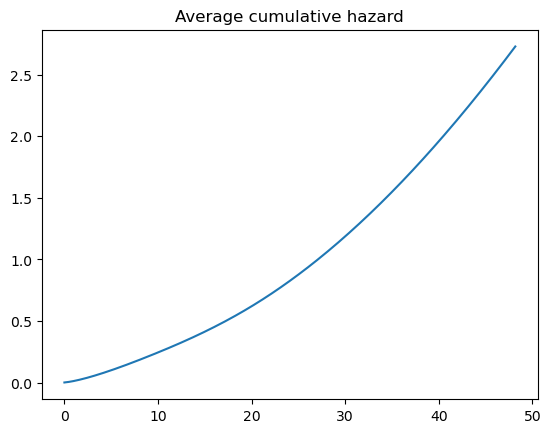

In [69]:
avg_haz, se_haz = average_curve_from_long(haz_long)
avg_cumhaz, se_cumhaz = average_curve_from_long(cumhaz_long)

# plot average hazard (no CI calculation for hazards done here, but same approach applies)
plt.plot(avg_haz.index, avg_haz.values)
plt.title("Average hazard")
plt.show()

plt.plot(avg_cumhaz.index, avg_cumhaz.values)
plt.title("Average cumulative hazard")
plt.show()


In [70]:
# ---------- median survival per individual --------------
def median_from_long(long_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute median survival time per individual (time where value <= 0.5), interpolated.
    long_df expected to be survival (value = S(t)).
    Returns DataFrame with columns: id, median (np.nan if median not reached within grid)
    """
    medians = []
    for idx in sorted(long_df["id"].unique()):
        sub = long_df[long_df["id"] == idx].sort_values("time")
        t = sub["time"].values
        s = sub["value"].values
        if s[0] <= 0.5:
            med = 0.0
        elif s[-1] > 0.5:
            med = np.nan  # median not reached within grid
        else:
            # find first index where s <= 0.5
            k = np.where(s <= 0.5)[0][0]
            t1, t0 = t[k], t[k-1]
            s1, s0 = s[k], s[k-1]
            # linear interpolation for median
            med = t0 + (0.5 - s0) * (t1 - t0) / (s1 - s0)
        medians.append({"id": idx, "median": med})
    return pd.DataFrame(medians)

surv_long = predict_type_multi(fp_model, df1, pred_type="surv", max_time=df1['time'].max(), se_fit=False)
medians_df = median_from_long(surv_long)
print(medians_df.head())

   id     median
0   0  25.125712
1   1  25.125712
2   2  18.839174
3   3  25.125712
4   4  25.125712


In [71]:
# ---------- RMST per individual --------------“On average, how long does an individual survive up to time τ?”
def rmst_from_long(long_df: pd.DataFrame, tau: Optional[float] = None) -> pd.DataFrame:
    """
    Compute RMST up to tau for each individual by trapezoidal integration of S(t).
    If tau is None, uses max time in long_df.
    Returns DataFrame with columns: id, rmst
    """
    if tau is None:
        tau = long_df["time"].max()

    rms = []
    for idx in sorted(long_df["id"].unique()):
        sub = long_df[long_df["id"] == idx].sort_values("time")
        t = sub["time"].values
        s = sub["value"].values
        # restrict to [0,tau]
        if t[-1] < tau:
            # extend by last value constant (assume last known)
            t_ext = np.append(t, tau)
            s_ext = np.append(s, s[-1])
            area = np.trapz(s_ext, t_ext)
        else:
            # interpolate to exact tau if needed
            if tau in t:
                mask = t <= tau
                area = np.trapz(s[mask], t[mask])
            else:
                # include interpolation point
                s_tau = np.interp(tau, t, s)
                mask = t <= tau
                t_sel = np.append(t[mask], tau)
                s_sel = np.append(s[mask], s_tau)
                area = np.trapz(s_sel, t_sel)
        rms.append({"id": idx, "rmst": float(area)})
    return pd.DataFrame(rms)

tau = 12.0  # pick clinically relevant tau
rmst_df = rmst_from_long(surv_long, tau=tau)
print(rmst_df.head())
# population RMST:
pop_rmst = rmst_df['rmst'].mean()
print("Population RMST up to", tau, "=", pop_rmst)


   id       rmst
0   0  10.817299
1   1  10.817299
2   2  10.232083
3   3  10.817299
4   4  10.817299
Population RMST up to 12.0 = 10.52703197327098


/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_37525/4028906014.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(s_sel, t_sel)


In [72]:
# ---------- group comparisons (average curves + RMST diff bootstrap) --------------
def compare_groups(fp_model, data: pd.DataFrame, group_col: str, tau: Optional[float] = None, n_boot: int = 200, seed: Optional[int] = 42):
    """
    Compare groups defined by group_col.
    Returns dict with:
      - avg_curves: dict[group_value] -> (avg_series, se_series)
      - rmst_table: DataFrame with rmst per id and group
      - rmst_diff: point estimate difference (groupA - groupB) and bootstrap CI (if n_boot>0)
    Note: bootstrap can be slow because each bootstrap resamples rows and predicts.
    """
    np.random.seed(seed)
    groups = data[group_col].unique()
    if len(groups) != 2:
        raise ValueError("compare_groups currently supports exactly 2 groups.")

    g0, g1 = groups
    results = {}

    # average curves using model-based SEs if available
    long0 = predict_type_multi(fp_model, data[data[group_col] == g0].reset_index(drop=True), pred_type="surv", max_time=tau or data['time'].max(), se_fit=True)
    long1 = predict_type_multi(fp_model, data[data[group_col] == g1].reset_index(drop=True), pred_type="surv", max_time=tau or data['time'].max(), se_fit=True)

    avg0, se0 = average_curve_from_long(long0)
    avg1, se1 = average_curve_from_long(long1)
    results['avg_curves'] = {g0: (avg0, se0), g1: (avg1, se1)}

    # compute RMST per individual
    rmst0 = rmst_from_long(long0, tau=tau)
    rmst0[group_col] = g0
    rmst1 = rmst_from_long(long1, tau=tau)
    rmst1[group_col] = g1
    rmst_table = pd.concat([rmst0, rmst1], ignore_index=True)
    results['rmst_table'] = rmst_table

    # rmst point estimates
    rmst_mean0 = rmst0['rmst'].mean()
    rmst_mean1 = rmst1['rmst'].mean()
    results['rmst_mean'] = {g0: rmst_mean0, g1: rmst_mean1, 'diff': float(rmst_mean0 - rmst_mean1)}

    # bootstrap for RMST difference
    if n_boot > 0:
        boot_diffs = []
        n0 = len(rmst0)
        n1 = len(rmst1)
        for b in range(n_boot):
            # resample rows WITHIN group (non-parametric bootstrap)
            samp0_idx = np.random.choice(range(n0), size=n0, replace=True)
            samp1_idx = np.random.choice(range(n1), size=n1, replace=True)
            samp0 = data[data[group_col] == g0].reset_index(drop=True).iloc[samp0_idx]
            samp1 = data[data[group_col] == g1].reset_index(drop=True).iloc[samp1_idx]
            # predict and compute rmst means for resampled sets
            long0_b = predict_type_multi(fp_model, samp0.reset_index(drop=True), pred_type="surv", max_time=tau or data['time'].max(), se_fit=False)
            long1_b = predict_type_multi(fp_model, samp1.reset_index(drop=True), pred_type="surv", max_time=tau or data['time'].max(), se_fit=False)
            rmst0_b = rmst_from_long(long0_b, tau=tau)['rmst'].mean()
            rmst1_b = rmst_from_long(long1_b, tau=tau)['rmst'].mean()
            boot_diffs.append(rmst0_b - rmst1_b)
        lower = np.percentile(boot_diffs, 2.5)
        upper = np.percentile(boot_diffs, 97.5)
        results['rmst_diff_bootstrap'] = {"boot_diffs": np.array(boot_diffs), "ci": (lower, upper)}
    else:
        results['rmst_diff_bootstrap'] = None

    return results


In [73]:
# ---------- bootstrap for average survival confidence bands --------------
def bootstrap_average_curve(fp_model, data: pd.DataFrame, n_boot: int = 200, seed: Optional[int] = 42):
    """
    Bootstrap individuals to get pointwise confidence bands for the population average survival.
    Returns:
      - avg: original average series
      - lower, upper: arrays for bootstrap percentile CI
    Warning: expensive (n_boot x N predictions).
    """
    np.random.seed(seed)
    N = len(data)
    # original long
    long_orig = predict_type_multi(fp_model, data, pred_type="surv", max_time=data['time'].max(), se_fit=False)
    avg_orig, _ = average_curve_from_long(long_orig)
    time_index = avg_orig.index
    boot_avgs = []
    for b in range(n_boot):
        idxs = np.random.choice(range(N), size=N, replace=True)
        samp = data.iloc[idxs].reset_index(drop=True)
        long_b = predict_type_multi(fp_model, samp, pred_type="surv", max_time=data['time'].max(), se_fit=False)
        avg_b, _ = average_curve_from_long(long_b)
        boot_avgs.append(avg_b.values)
    boot_avgs = np.vstack(boot_avgs)  # n_boot x n_time
    lower = np.percentile(boot_avgs, 2.5, axis=0)
    upper = np.percentile(boot_avgs, 97.5, axis=0)
    lower_s = pd.Series(lower, index=time_index)
    upper_s = pd.Series(upper, index=time_index)
    return avg_orig, lower_s, upper_s

In [74]:
# ---------- plotting helpers --------------
def plot_average_with_CI(avg_series: pd.Series, se_series: Optional[pd.Series] = None,
                         lower: Optional[pd.Series] = None, upper: Optional[pd.Series] = None,
                         label: str = "Average survival"):
    """
    Plot average series with either model-based CI (from se_series) or provided lower/upper series.
    """
    plt.figure(figsize=(5,4))
    plt.plot(avg_series.index, avg_series.values, label=label, lw=2)
    if se_series is not None and not se_series.isna().all():
        lo, hi = pointwise_CI(avg_series, se_series)
        plt.fill_between(avg_series.index, lo, hi, alpha=0.2, label='95% CI (model-based)')
    elif lower is not None and upper is not None:
        plt.fill_between(avg_series.index, lower.values, upper.values, alpha=0.2, label='95% CI (bootstrap)')
    plt.xlabel("Time")
    plt.ylabel("Survival probability")
    plt.title(label)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# res = compare_groups(fp_model, df1, group_col="treatment", tau=12.0, n_boot=20)
# # average curves:
# avg0, se0 = res['avg_curves'][res['avg_curves'].keys().__iter__().__next__()]  # not pretty — see below for nicer access
# # nicer:
# groups = list(res['avg_curves'].keys())
# gA, gB = groups[0], groups[1]
# avgA, seA = res['avg_curves'][gA]
# avgB, seB = res['avg_curves'][gB]


In [75]:
def plot_group_comparison(res, title="Average Survival by Group"):
    """
    Plot the two average survival curves from compare_groups()
    on the same graph with CI bands.
    """
    import matplotlib.pyplot as plt

    groups = list(res["avg_curves"].keys())
    gA, gB = groups[0], groups[1]

    avgA, seA = res["avg_curves"][gA]
    avgB, seB = res["avg_curves"][gB]

    timeA = avgA.index.values
    timeB = avgB.index.values

    # 95% CI
    A_lo = avgA.values - 1.96 * seA.values
    A_hi = avgA.values + 1.96 * seA.values
    B_lo = avgB.values - 1.96 * seB.values
    B_hi = avgB.values + 1.96 * seB.values

    plt.figure(figsize=(9, 6))

    # --- Group A ---
    plt.plot(timeA, avgA, label=f"{gA} mean survival", linewidth=2)
    plt.fill_between(timeA, A_lo, A_hi, alpha=0.25)

    # --- Group B ---
    plt.plot(timeB, avgB, label=f"{gB} mean survival", linewidth=2)
    plt.fill_between(timeB, B_lo, B_hi, alpha=0.25)

    plt.xlabel("Time")
    plt.ylabel("Survival probability")
    plt.title(title)
    plt.ylim(0, 1.02)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_37525/4028906014.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(s[mask], t[mask])
/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_37525/4028906014.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(s[mask], t[mask])
/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_37525/4028906014.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(s[mask], t[mask])


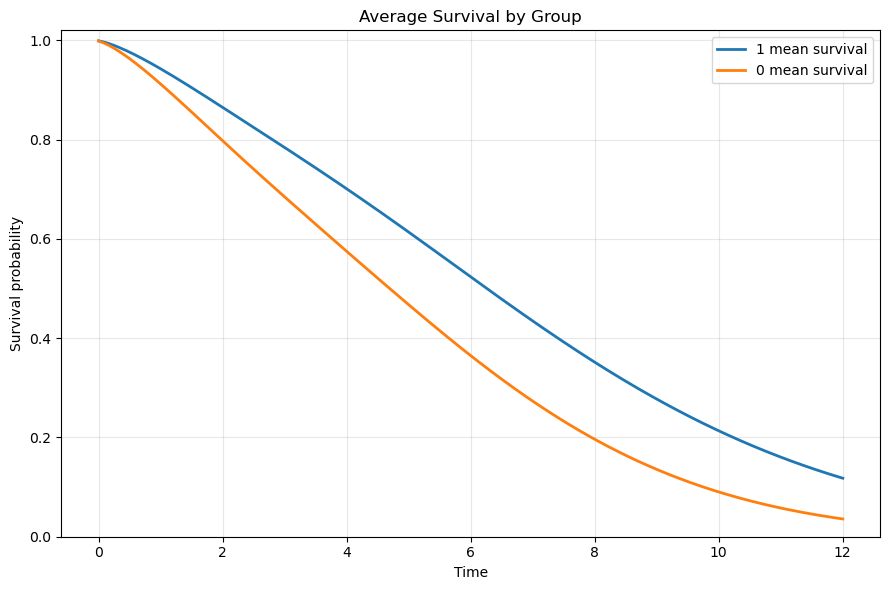

RMST means: {np.int64(1): np.float64(6.425126418246294), np.int64(0): np.float64(5.068498193255267), 'diff': 1.3566282249910273}
RMST diff bootstrap CI: (np.float64(1.3566282249910273), np.float64(1.3566282249910273))


In [76]:
res = compare_groups(fp_model, df1, group_col="treatment", tau=12.0, n_boot=20)

plot_group_comparison(res)

print("RMST means:", res['rmst_mean'])
print("RMST diff bootstrap CI:", res['rmst_diff_bootstrap']['ci'])


In [77]:
# Prepare new data with multiple rows
new_data = pd.DataFrame({
    "age": [60, 50, 70],
    "treatment": [1, 0, 1]
})

# Predict survival for all rows
surv_long = predict_survival_multi(fp_model, newdata = new_data, max_time=df1['time'].max())
print(surv_long.head())


   id      time      surv
0   0  0.000000  0.998896
1   0  0.161643  0.997844
2   0  0.323287  0.996579
3   0  0.484930  0.995139
4   0  0.646573  0.993548


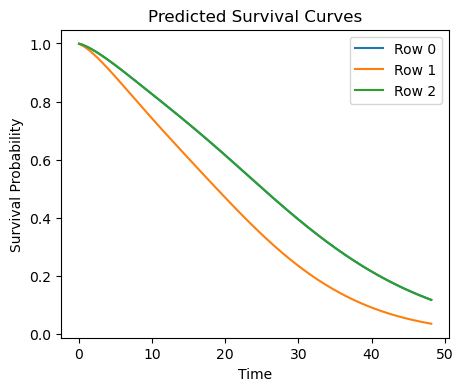

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))

for idx in surv_long['id'].unique():
    df = surv_long[surv_long['id'] == idx]
    plt.plot(df['time'], df['surv'], label=f'Row {idx}')

plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curves")
plt.legend()
plt.show()
